In [42]:
import os
import cv2
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transfBhattacharyyaorms
import utils
from discriminators import define_Dis
from generators import define_Gen
import numpy as np

In [43]:
crop_height = 128
crop_width = 128
dataset_dir = './datasets/sketch2waterpokemon'
checkpoint_dir = './checkpoints'
checkpoint_name = 'latest'
results_dir = './results'
batch_size = 1
ngf = 64
norm = 'instance'
no_dropout = False
gpu_ids = []#[0]

test_length = 5

In [6]:
utils.create_link(dataset_dir)

{'trainA': './datasets/sketch2pokemon/ltrainA',
 'trainB': './datasets/sketch2pokemon/ltrainB',
 'testA': './datasets/sketch2pokemon/ltestA',
 'testB': './datasets/sketch2pokemon/ltestB'}

In [44]:
transform = transforms.Compose(
    [transforms.Resize((crop_height,crop_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset_dirs = utils.get_testdata_link(dataset_dir)

a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)


a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=batch_size, shuffle=False, num_workers=4) # set shuffle to false for testing
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Gab = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)
Gba = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)

utils.print_networks([Gab,Gba], ['Gab','Gba'])

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
-----------------------------------------------


In [50]:
try:
    ckpt = utils.load_checkpoint('%s/%s.ckpt' % (checkpoint_dir, checkpoint_name))
    Gab.load_state_dict(ckpt['Gab'])
    Gba.load_state_dict(ckpt['Gba'])
except:
    print(' [*] No checkpoint!')

 [*] Loading checkpoint from ./checkpoints/latest.ckpt succeed!


In [46]:
a_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainA'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainB'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)

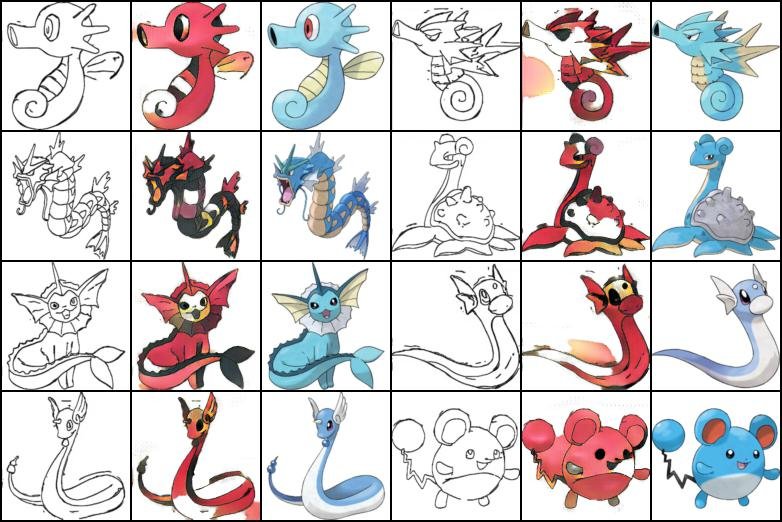

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

def gen(idx=0):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    for i in range(idx+1):
        a = itera.next()
        b = iterb.next()
    a_real_test = Variable(a[0], requires_grad=True)
    b_real_test = Variable(b[0], requires_grad=True)
    a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
            

    Gab.eval()
    Gba.eval()

    with torch.no_grad():
        a_fake_test = Gab(b_real_test)
        b_fake_test = Gba(a_real_test)
        a_recon_test = Gab(b_fake_test)
        b_recon_test = Gba(a_fake_test)

        pic = (torch.cat([a_real_test, b_fake_test], dim=0).data + 1) / 2.0

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        torchvision.utils.save_image(pic, results_dir+'/sample_%d.jpg' % idx, nrow=3)

def print_test(len):
    correlation_scores, intersection_scores, bhat_scores = np.empty(len), np.empty(length), np.empty(length)
    
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    for i in range(len):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            a_fake_test = Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            a_recon_test = Gab(b_fake_test)
            b_recon_test = Gba(a_fake_test)
            bft = [b_fake_test]
            bft = (torch.cat(bft, dim=0).data + 1) / 2.0
            res.extend([a_real_test, b_fake_test, b_real_test])
            torchvision.utils.save_image(bft, results_dir + '/output_%d.jpg' % i)
#             npimg = b_fake_test.cpu().numpy().reshape(128, 128, 3)
#             plt.imshow(np.transpose(npimg), interpolation='nearest')

    cs_std = np.std(correlation_scores)
    cs_mean = np.mean(correlation_scores)
    is_std = np.std(intersection_scores)
    is_mean = np.mean(intersection_scores)
    bs_std = np.std(bhat_scores)
    bs_mean = np.mean(bhat_scores)
    print("----- AGGREGATE SCORES -----")
    print("Correlation: ", cs_mean, " +- ", cs_std)
    print("Intersection: ", is_mean, " +- ", is_std)
    print("Bhat score: ", bs_mean, " +- ", bs_std)
    print("\n----- INDIVIDUAL SCORES -----")
    print("### Corr")
    print(correlation_scores)
    print("### Inter")
    print(intersection_scores)
    print("### Bhat")
    print(bhat_scores)
    
    pic = (torch.cat(res, dim=0).data + 1) / 2.0

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    torchvision.utils.save_image(pic, results_dir+'/result_%d.jpg' % ckpt['epoch'], nrow=6)

# idx = 16
# gen(idx)
# from IPython.display import Image
# Image(filename=results_dir+'/sample_%d.jpg' % idx) 

print_test(8)

from IPython.display import Image
Image(filename=results_dir+'/result_%d.jpg' % ckpt['epoch']) 

# RUN THIS FOR METRICS YA :]

In [59]:
import cv2

def computeMetricsHSV(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = imga
    hsv_test1 = imgb
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 256]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat

In [68]:
baseline_corr, baseline_chisq, baseline_inter, baseline_bhat = [],[],[],[]
improved_corr, improved_chisq, improved_inter, improved_bhat = [],[],[],[]
for i in range(8):
    truth = cv2.imread(results_dir + '/metrics_comparison/water_truth/output_%d.jpg' % i)
    baseline = cv2.imread(results_dir + '/metrics_comparison/water_baseline/output_%d.jpg' % i)
    improved = cv2.imread(results_dir + '/metrics_comparison/water_ours/output_%d.jpg' % i)
    a,b,c,d = computeMetricsHSV(baseline, truth)
    baseline_corr.append(a)
    baseline_chisq.append(b)
    baseline_inter.append(c)
    baseline_bhat.append(d)
    a,b,c,d = computeMetricsHSV(improved, truth)
    improved_corr.append(a)
    improved_chisq.append(b)
    improved_inter.append(c)
    improved_bhat.append(d)
print("chi squared (smaller)")
print("baseline: ", np.mean(baseline_chisq), np.std(baseline_chisq))
print("improved: ", np.mean(improved_chisq), np.std(improved_chisq))
print("intersection (larger)")
print("baseline: ", np.mean(baseline_inter), np.std(baseline_inter))
print("improved: ", np.mean(improved_inter), np.std(improved_inter))
print("bhat (smaller)")
print("baseline: ", np.mean(baseline_bhat), np.std(baseline_bhat))
print("improved: ", np.mean(improved_bhat), np.std(improved_bhat))

chi squared (smaller)
baseline:  2.880507752587195 1.8092273386451918
improved:  4.073060507422588 1.652890500933628
intersection (larger)
baseline:  1.108153558150434 0.017088739056076253
improved:  1.1567214085528121 0.030777684186923192
bhat (smaller)
baseline:  0.6692828576323104 0.05518103758277951
improved:  0.649224437940007 0.051872437849332584


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import eval_utils as Utils

In [69]:
def readImage(path):
    return cv2.imread(path)

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat
    
# Utils.ssim_score(img1, img2, data_range=1.0)
# Utils.psnr_score(img1, img2)
### Utils.inception_score()

def spatialBinnedMetrics(imga, imgb, num_hor=4, num_ver=4):
    # default 4 x 4
    #assume a and b same shape
    print(imga.shape)
    h,w, _ = imga.shape
    dx = int(w / num_hor)
    dy = int(h / num_ver)
    
    corr, chisq, inter, bhat = 0,0,0,0
    for i in range(num_ver):
        for j in range(num_hor):
            patch_a = imga[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            patch_b = imgb[i*dy : (i+1)*dy, j*dx : (j+1)*dx]
            co, cs, inte, bh = computeMetrics(patch_a, patch_b)
            corr += co
            chisq += cs
            inter += inte
            bhat += bh
    corr /= num_hor * num_ver
    chisq /= num_hor * num_ver
    inter /= num_hor * num_ver
    bhat /= num_hor * num_ver
    
    print("\nfinal: -----")
    print("correlation: ", corr)
    print("chi square: ", chisq)
    print("intersection: ", inter)
    print("bhat: ", bhat)
    
    return corr, chisq, inter, bhat
            
            
#     raise NotImplementedError()

In [11]:
pokemon = ['lapras, omastar, staryu, dunspace'] #bbyy
testevaldir = './datasets/test_metrics/'
imgType = ['_grey.jpg', '_res.jpg', '.jpg']

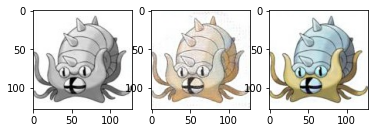

In [15]:
# img1path = './datasets/sketch2pokemon/testB/90_B.jpg'
# img2path = './datasets/sketch2pokemon/testB/91_B.jpg'
# poke = pokemon[0]
# img2path = testevaldir+poke+imgType[2]
# img1path = testevaldir+poke+imgType[0]
img1path = './datasets/test_metrics/omastar_grey.jpg'
img2path = './datasets/test_metrics/omastar_res.jpg'
img3path = './datasets/test_metrics/omastar.jpg'

imga = readImage(img1path)
imgb = readImage(img2path)
imgc = readImage(img3path)

plt.subplot(131)
plt.imshow(imga)
plt.subplot(132)
plt.imshow(imgb)
plt.subplot(133)
plt.imshow(imgc)
plt.show()

In [66]:
def eval_print(label, img1, img2, isPrint=False):
    print(label, "-----")
    print("ssim: ", Utils.ssim_score(img1, img2, data_range=1.0))
    print("psnr: ", Utils.psnr_score(img1, img2))
    computeMetrics(img1, img2, isPrint=isPrint)

### Dunspace eg

In [46]:
eval_print("# GREY", imga, imgc) #dunspace
eval_print('# RES', imgb, imgc)
eval_print('# IDENTITY', imgc, imgc)

# GREY -----
ssim:  0.6555545853036059
psnr:  -15.866849904587177
HistCompare_correlation:  0.9680611559673097
HistCompare_chi_square:  0.649104106234767
HistCompare_intersction:  1.0276446732168552
HistCompare_bhat:  0.7173556032913327
# RES -----
ssim:  0.5101829934490879
psnr:  -16.18619808043366
HistCompare_correlation:  0.9923309905646013
HistCompare_chi_square:  2.0146916625546196
HistCompare_intersction:  1.659558443876449
HistCompare_bhat:  0.5560911664814896
# IDENTITY -----
ssim:  1.0
psnr:  inf
HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  3.0195355681644287
HistCompare_bhat:  0.0


In [57]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

(128, 128, 3)

final: -----
correlation:  0.6343935906233442
chi square:  1.4701245766612476
intersection:  0.8952105891803512
bhat:  0.6932177567258963
(128, 128, 3)

final: -----
correlation:  0.729458505909253
chi square:  21.800707429709874
intersection:  2.7953753328256425
bhat:  0.6183805415670456
(128, 128, 3)

final: -----
correlation:  1.0
chi square:  0.0
intersection:  16.14142613601871
bhat:  3.2927225399135964e-09


(1.0, 0.0, 16.14142613601871, 3.2927225399135964e-09)

### Staryu eg

In [44]:
eval_print("# GREY", imga, imgc) #staryu
eval_print('# RES', imgb, imgc)
eval_print('# IDENTITY', imgc, imgc)

# GREY -----
ssim:  0.695588760439142
psnr:  -16.918313966645833
HistCompare_correlation:  0.9442322500173828
HistCompare_chi_square:  1.1837266293437905
HistCompare_intersction:  1.0252829280216247
HistCompare_bhat:  0.8025067223090334
# RES -----
ssim:  0.577801051244594
psnr:  -17.615392893873494
HistCompare_correlation:  0.9757632635550221
HistCompare_chi_square:  5.822236185940446
HistCompare_intersction:  2.218782646494219
HistCompare_bhat:  0.584806027925525
# IDENTITY -----
ssim:  1.0
psnr:  inf
HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  3.945099853735883
HistCompare_bhat:  0.0


In [59]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

(128, 128, 3)

final: -----
correlation:  0.5608034675246332
chi square:  3.6473879172331434
intersection:  0.7570859762781765
bhat:  0.781852030530714
(128, 128, 3)

final: -----
correlation:  0.5968094809153316
chi square:  22.326962635900497
intersection:  2.7734927202327526
bhat:  0.7121815692874879
(128, 128, 3)

final: -----
correlation:  1.0
chi square:  0.0
intersection:  24.710439540205698
bhat:  1.975633523948158e-09


(1.0, 0.0, 24.710439540205698, 1.975633523948158e-09)

### lapras eg

In [67]:
eval_print("# GREY", imga, imgc, isPrint=True) #lapras
eval_print('# RES', imgb, imgc, isPrint=True)
eval_print('# IDENTITY', imgc, imgc, isPrint=True)

# GREY -----
ssim:  0.7379370704624306
psnr:  -15.9009658142365
HistCompare_correlation:  0.9812889588928655
HistCompare_chi_square:  1.1349482440203553
HistCompare_intersction:  1.0324710920831421
HistCompare_bhat:  0.7083211042521314
# RES -----
ssim:  0.506196238171216
psnr:  -16.75334500960883
HistCompare_correlation:  0.9731962900014445
HistCompare_chi_square:  2.0000839017985843
HistCompare_intersction:  1.6246584836480906
HistCompare_bhat:  0.5971450981746639
# IDENTITY -----
ssim:  1.0
psnr:  inf
HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  2.6567213193775387
HistCompare_bhat:  0.0


/home/ykaixin/Desktop/3244-2010-0023/eval_utils.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10(1.0 / mse)


In [68]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

(128, 128, 3)

final: -----
correlation:  0.5829933606401203
chi square:  2.502611822153056
intersection:  0.910586618942034
bhat:  0.6433603020743579
(128, 128, 3)

final: -----
correlation:  0.6761029093037405
chi square:  18.438723120202507
intersection:  3.5513590974078397
bhat:  0.646052749665574
(128, 128, 3)

final: -----
correlation:  1.0
chi square:  0.0
intersection:  19.729487795928435
bhat:  1.3170890159654386e-09


(1.0, 0.0, 19.729487795928435, 1.3170890159654386e-09)

### omastar eg

In [71]:
eval_print("# GREY", imga, imgc, isPrint=True) #lapras
eval_print('# RES', imgb, imgc, isPrint=True)
eval_print('# IDENTITY', imgc, imgc, isPrint=True)

# GREY -----
ssim:  0.7252761177905016
psnr:  -17.07368466403054
HistCompare_correlation:  0.9419433496631583
HistCompare_chi_square:  2.5156974559510497
HistCompare_intersction:  1.0429204360116273
HistCompare_bhat:  0.8077965836968405
# RES -----
ssim:  0.6166239172412861
psnr:  -17.75498775918165
HistCompare_correlation:  0.9738455166529804
HistCompare_chi_square:  4.216496059741116
HistCompare_intersction:  2.248602944659069
HistCompare_bhat:  0.7030884770374259
# IDENTITY -----
ssim:  1.0
psnr:  inf
HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  4.600954981986433
HistCompare_bhat:  0.0


In [72]:
spatialBinnedMetrics(imga, imgc)
spatialBinnedMetrics(imgb, imgc)
spatialBinnedMetrics(imgc, imgc)

(128, 128, 3)

final: -----
correlation:  0.4927360056319909
chi square:  3.1398632662665866
intersection:  0.7159420598909492
bhat:  0.791353331037506
(128, 128, 3)

final: -----
correlation:  0.5462158243422287
chi square:  26.33108481675287
intersection:  2.43318929283123
bhat:  0.7592025404135836
(128, 128, 3)

final: -----
correlation:  1.0
chi square:  0.0
intersection:  20.549949389307585
bhat:  1.3170890159654386e-09


(1.0, 0.0, 20.549949389307585, 1.3170890159654386e-09)

### Dump

In [18]:
computeMetrics(imga, imgb) #exact same ghastly

HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  3.0995080839202274
HistCompare_bhat:  0.0


In [26]:
computeMetrics(imga, imgb) #onix onix

HistCompare_correlation:  1.0
HistCompare_chi_square:  0.0
HistCompare_intersction:  1.9458432234896463
HistCompare_bhat:  1.0536712127723509e-08


from here can see that intersection and bhat is not ideal cus dif values despite identity

In [20]:
computeMetrics(imga, imgb) #ghastly haunter

HistCompare_correlation:  0.9799285476041358
HistCompare_chi_square:  2.0154848364415345
HistCompare_intersction:  1.0820836799575773
HistCompare_bhat:  0.6975679657159936


In [22]:
computeMetrics(imga, imgb) #ghastly gengar

HistCompare_correlation:  0.9736436601484993
HistCompare_chi_square:  2.1930900109101694
HistCompare_intersction:  1.0864145131054102
HistCompare_bhat:  0.758480429005484


In [24]:
computeMetrics(imga, imgb) #ghastly onix

HistCompare_correlation:  0.9783083282890952
HistCompare_chi_square:  2.4059933619973037
HistCompare_intersction:  1.0692740663944278
HistCompare_bhat:  0.7401755124697869


In [28]:
computeMetrics(imga, imgb) #ghastly mutant_drowzee

HistCompare_correlation:  0.969588566348377
HistCompare_chi_square:  10.879578888325456
HistCompare_intersction:  1.1577566423584358
HistCompare_bhat:  0.7142052625568617


chisq seems gd ah

In [34]:
computeMetrics(imga, imgb) #ghastly caterpie

HistCompare_correlation:  0.9767693072593291
HistCompare_chi_square:  2.3627164266046816
HistCompare_intersction:  1.129925356239255
HistCompare_bhat:  0.7505798071510059


# Dump (to ignore)

In [8]:
def save_sample_image(test_length):
    temp_dir = './temp'
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    average_hist_score_correlation = 0.0
    average_hist_score_chi_square = 0.0
    average_hist_score_intersction = 0.0
    average_hist_score_bhat = 0.0
    for i in range(test_length):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            # a_fake_test = self.Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            # a_recon_test = self.Gab(b_fake_test)
            # b_recon_test = self.Gba(a_fake_test)

            res.extend([a_real_test, b_fake_test, b_real_test])

            ##### Generate histogram similarity score
            # Documentation: https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
            torchvision.utils.save_image(b_fake_test.cpu(), temp_dir + '/model_output' + i + '.jpg')
            torchvision.utils.save_image(b_real_test.cpu(), temp_dir + '/groundtruth' + i + '.jpg')
            src_base = cv2.imread(temp_dir + '/groundtruth.jpg')
            src_test1 = cv2.imread(temp_dir + '/model_output.jpg')
            hsv_base = cv2.cvtColor(src_base, cv2.COLOR_BGR2HSV)
            hsv_test1 = cv2.cvtColor(src_test1, cv2.COLOR_BGR2HSV)
            h_bins = 50
            s_bins = 60
            v_bins = 60
            histSize = [h_bins, s_bins, v_bins]
            # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
            h_ranges = [0, 180]
            s_ranges = [0, 256]
            v_ranges = [0, 256]
            ranges = h_ranges + s_ranges + v_ranges# concat lists
            # Use 0,1,2nd channels
            channels = [0, 1, 2]
            hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
            cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
            corr = cv2.compareHist(hist_base, hist_test1, 0)
            average_hist_score_correlation += corr
            chisq = cv2.compareHist(hist_base, hist_test1, 1)
            average_hist_score_chi_square += chisq
            intersectn = cv2.compareHist(hist_base, hist_test1, 2)
            average_hist_score_intersction += intersectn
            bhat = cv2.compareHist(hist_base, hist_test1, 3)
            average_hist_score_bhat += bhat
            # os.remove(temp_dir + '/model_output.jpg')
            # os.remove(temp_dir + '/groundtruth.jpg')
            print('HistCompare_correlation: ', corr)
            print('HistCompare_chi_square: ', chisq)
            print('HistCompare_intersction: ', intersectn)
            print('HistCompare_bhat: ', bhat)

    print('aveHistCompare_correlation: ', average_hist_score_correlation / test_length)
    print('aveHistCompare_chi_square: ', average_hist_score_chi_square / test_length)
    print('aveHistCompare_intersction: ', average_hist_score_intersction / test_length)
    print('aveHistCompare_bhat: ', average_hist_score_bhat / test_length)


In [9]:
save_sample_image(5)

TypeError: 'NoneType' object is not iterable